# CIS 519 Final Project: Predicting Future Stock Price Movement with Machine Learning

In [ ]:
# import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, math
from pylab import rcParams
import random 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel, SelectKBest

from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.utils.tensorboard as tb
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import torchvision as thv
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Dataset, Preprocess

In [ ]:
# import dataset from Google Drive
df_aapl = pd.read_csv('/content/drive/Shareddrives/CIS 519 project/AAPL.csv')
df_aapl

,Date,Open,High,Low,Close(t),Volume,SD20,Upper_Band,Lower_Band,S_Close(t-1),S_Close(t-2),S_Close(t-3),S_Close(t-5),S_Open(t-1),MA5,MA10,MA20,MA50,MA200,EMA10,EMA20,EMA50,EMA100,EMA200,MACD,MACD_EMA,ATR,ADX,CCI,ROC,RSI,William%R,SO%K,STD5,ForceIndex1,ForceIndex20,Date_col,Day,DayofWeek,DayofYear,Week,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Is_leap_year,Year,Month,QQQ_Close,QQQ(t-1),QQQ(t-2),QQQ(t-5),QQQ_MA10,QQQ_MA20,QQQ_MA50,SnP_Close,SnP(t-1)),SnP(t-5),DJIA_Close,DJIA(t-1)),DJIA(t-5),Close_forcast
0,2005-10-17,6.66,6.69,6.50,6.60,154208600,0.169237,6.827473,6.150527,6.67,6.63,6.08,6.22,6.67,6.470,6.444,6.4890,6.0978,5.14710,6.523675,6.523675,6.523675,6.523675,6.523675,0.108024,0.126360,0.226843,25.267370,1333.333333,-1.785714,56.769238,-25.000000,75.000000,0.050372,-1.079460e+07,1.542086e+07,2005-10-17,17,0,290,42,0,0,0,0,0,0,0,2005,10,33.65,33.55,33.30,33.61,33.692,33.9970,34.2690,1190.10,1186.57,1187.33,10348.10,10287.34,10238.76,6.45
1,2005-10-18,6.57,6.66,6.44,6.45,152397000,0.168339,6.819677,6.146323,6.60,6.67,6.63,6.37,6.66,6.486,6.425,6.4830,6.1214,5.15980,6.499117,6.499117,6.499117,6.499117,6.499117,0.098400,0.120768,0.226355,23.873006,1333.333333,-2.861446,52.468220,-41.304348,58.695652,0.052096,-2.285955e+07,-1.828764e+07,2005-10-18,18,1,291,42,0,0,0,0,0,0,0,2005,10,33.42,33.65,33.55,33.44,33.570,33.9525,34.2466,1178.14,1190.10,1184.87,10285.26,10348.10,10253.17,6.78
2,2005-10-19,6.43,6.78,6.32,6.78,252170800,0.180306,6.861112,6.139888,6.45,6.60,6.67,6.08,6.57,6.626,6.451,6.5005,6.1488,5.17395,6.592744,6.592744,6.592744,6.592744,6.592744,0.116064,0.119827,0.243043,22.578240,1333.333333,3.987730,59.701770,-5.434783,94.565217,0.047023,8.321636e+07,8.825978e+07,2005-10-19,19,2,292,42,0,0,0,0,0,0,0,2005,10,34.09,33.42,33.65,33.05,33.562,33.9600,34.2330,1195.76,1178.14,1177.68,10414.13,10285.26,10216.91,6.93
3,2005-10-20,6.72,6.97,6.71,6.93,339440500,0.202674,6.931847,6.121153,6.78,6.45,6.60,6.63,6.43,6.686,6.506,6.5265,6.1802,5.18870,6.705163,6.705163,6.705163,6.705163,6.705163,0.140547,0.123971,0.244255,22.190130,1333.333333,8.620690,62.495670,-3.773585,96.226415,0.028919,5.091607e+07,1.765091e+08,2005-10-20,20,3,293,42,0,0,0,0,0,0,0,2005,10,33.77,34.09,33.42,33.30,33.567,33.9455,34.2190,1177.80,1195.76,1176.84,10281.10,10414.13,10216.59,6.87
4,2005-10-21,7.02,7.03,6.83,6.87,199181500,0.216680,6.974860,6.108140,6.93,6.78,6.45,6.67,6.72,6.726,6.560,6.5415,6.2090,5.20315,6.760109,6.760109,6.760109,6.760109,6.760109,0.153340,0.129845,0.241094,22.063526,1333.333333,8.530806,60.683333,-14.285714,85.714286,0.030048,-1.195089e+07,5.975445e+07,2005-10-21,21,4,294,42,0,0,0,0,0,0,0,2005,10,33.98,33.77,34.09,33.55,33.586,33.9365,34.2034,1179.59,1177.80,1186.57,10215.22,10281.10,10287.34,7.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3727,2020-08-07,452.82,454.70,441.17,444.45,49453300,27.954399,455.316298,343.498702,454.79,439.46,437.87,424.28,440.83,442.308,415.027,399.4075,370.3528,304.48200,438.152509,438.152509,438.152509,438.152509,438.152509,20.908358,15.211138,12.474742,41.364079,1333.333333,20.189837,73.038930,-12.270790,87.729210,0.022205,-5.113471e+08,3.039400e+09,2020-08-07,7,4,220,32,0,0,0,0,0,0,1,2020,8,271.47,274.64,271.05,265.79,266.054,263.4085,252.2098,3351.28,3349.16,3271.12,27433.48,27386.98,26428.32,450.91
3728,2020-08-10,450.40,455.10,440.00,450.91,53100900,29.847338,462.586675,343.197325,444.45,454.79,439.46,434.97,452.82,445.496,422.262,402.8920,373.0236,305.53260,442.405006,442.405006,442.405006,442.405006,442.405006,21.936462,16.556202,12.662261,42.739093,1333.333333,19.111898,74.615945,-5.867777,94.132223,0.020792,3.430318e+08,3.700602e+09,2020-08-10,10,0,223,33,0,0,0,0,0,0,1,2020,8,270.31,271.47,274.64,269.38,267.073,263.9970,252.9570,3360.47,3

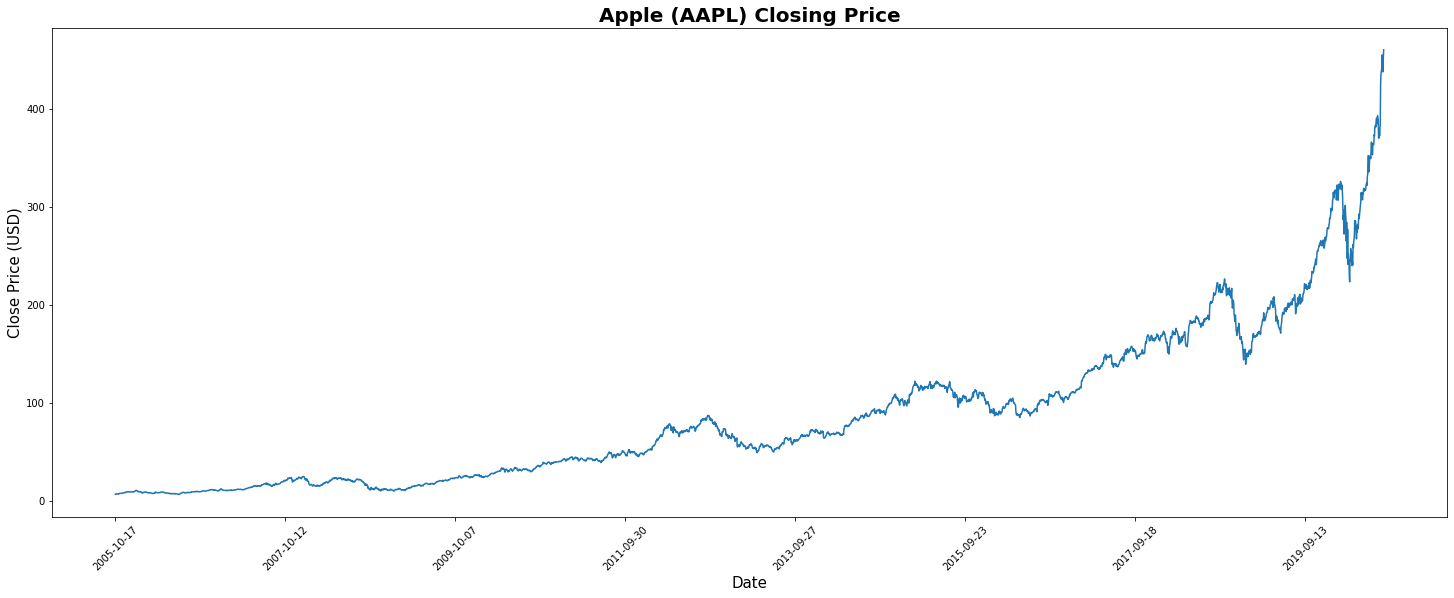

In [ ]:
def visualize(df):
  plt.figure(figsize = (25,9))
  plt.plot(df[['Close(t)']])
  plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
  plt.title("Apple (AAPL) Closing Price",fontsize=20, fontweight='bold')
  plt.xlabel('Date',fontsize=15)
  plt.ylabel('Close Price (USD)',fontsize=15)
  plt.show()

visualize(df_aapl)

In [ ]:
# pre-processing
def preprocess(df):
    '''
    Args:
        df: dataset to preprocess

    Returns: 
        preprocessed dataset
    '''

    # add classifier column "Movement" that shows the movement of the closing price "Close(t)" from Date t to Date t+1
    # 1 indicates a higher closing price the next day & -1 indicates a lower closing price the next day
    df["Movement Next Day"] = np.where(df['Close(t)'].shift(-1) > df['Close(t)'],1,-1)

    # drop NA 
    df = df.dropna()

    # remove outlier, 2008-09 Financial Crisis: remove data from January 1, 2008 - December 31, 2009 
    df = df.loc[(df['Date'] < '2008-01-01') | (df['Date'] > '2009-12-31')]

    # remove outlier, 'Covid Market Crash': remove data from March 1, 2020 - April 30, 2020
    df = df.loc[(df['Date'] < '2020-03-01') | (df['Date'] > '2020-04-30')]

    # drop unnecessary columns
    df = df.drop(columns = ['Date','Date_col',	'Day',	'DayofWeek',	'DayofYear',	'Week', 'Is_month_end',	'Is_month_start',	'Is_quarter_end',	'Is_quarter_start',	'Is_year_end',	'Is_year_start',	'Is_leap_year', 'Year',	'Month'])

    return df

# pre-process the dataset
df_aapl = preprocess(df_aapl)
df_aapl

,Open,High,Low,Close(t),Volume,SD20,Upper_Band,Lower_Band,S_Close(t-1),S_Close(t-2),S_Close(t-3),S_Close(t-5),S_Open(t-1),MA5,MA10,MA20,MA50,MA200,EMA10,EMA20,EMA50,EMA100,EMA200,MACD,MACD_EMA,ATR,ADX,CCI,ROC,RSI,William%R,SO%K,STD5,ForceIndex1,ForceIndex20,QQQ_Close,QQQ(t-1),QQQ(t-2),QQQ(t-5),QQQ_MA10,QQQ_MA20,QQQ_MA50,SnP_Close,SnP(t-1)),SnP(t-5),DJIA_Close,DJIA(t-1)),DJIA(t-5),Close_forcast,Movement Next Day
0,6.66,6.69,6.50,6.60,154208600,0.169237,6.827473,6.150527,6.67,6.63,6.08,6.22,6.67,6.470,6.444,6.4890,6.0978,5.14710,6.523675,6.523675,6.523675,6.523675,6.523675,0.108024,0.126360,0.226843,25.267370,1333.333333,-1.785714,56.769238,-25.000000,75.000000,0.050372,-1.079460e+07,1.542086e+07,33.65,33.55,33.30,33.61,33.692,33.9970,34.2690,1190.10,1186.57,1187.33,10348.10,10287.34,10238.76,6.45,-1
1,6.57,6.66,6.44,6.45,152397000,0.168339,6.819677,6.146323,6.60,6.67,6.63,6.37,6.66,6.486,6.425,6.4830,6.1214,5.15980,6.499117,6.499117,6.499117,6.499117,6.499117,0.098400,0.120768,0.226355,23.873006,1333.333333,-2.861446,52.468220,-41.304348,58.695652,0.052096,-2.285955e+07,-1.828764e+07,33.42,33.65,33.55,33.44,33.570,33.9525,34.2466,1178.14,1190.10,1184.87,10285.26,10348.10,10253.17,6.78,1
2,6.43,6.78,6.32,6.78,252170800,0.180306,6.861112,6.139888,6.45,6.60,6.67,6.08,6.57,6.626,6.451,6.5005,6.1488,5.17395,6.592744,6.592744,6.592744,6.592744,6.592744,0.116064,0.119827,0.243043,22.578240,1333.333333,3.987730,59.701770,-5.434783,94.565217,0.047023,8.321636e+07,8.825978e+07,34.09,33.42,33.65,33.05,33.562,33.9600,34.2330,1195.76,1178.14,1177.68,10414.13,10285.26,10216.91,6.93,1
3,6.72,6.97,6.71,6.93,339440500,0.202674,6.931847,6.121153,6.78,6.45,6.60,6.63,6.43,6.686,6.506,6.5265,6.1802,5.18870,6.705163,6.705163,6.705163,6.705163,6.705163,0.140547,0.123971,0.244255,22.190130,1333.333333,8.620690,62.495670,-3.773585,96.226415,0.028919,5.091607e+07,1.765091e+08,33.77,34.09,33.42,33.30,33.567,33.9455,34.2190,1177.80,1195.76,1176.84,10281.10,10414.13,10216.59,6.87,-1
4,7.02,7.03,6.83,6.87,199181500,0.216680,6.974860,6.108140,6.93,6.78,6.45,6.67,6.72,6.726,6.560,6.5415,6.2090,5.20315,6.760109,6.760109,6.760109,6.760109,6.760109,0.153340,0.129845,0.241094,22.063526,1333.333333,8.530806,60.683333,-14.285714,85.714286,0.030048,-1.195089e+07,5.975445e+07,33.98,33.77,34.09,33.55,33.586,33.9365,34.2034,1179.59,1177.80,1186.57,10215.22,10281.10,10287.34,7.01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3727,452.82,454.70,441.17,444.45,49453300,27.954399,455.316298,343.498702,454.79,439.46,437.87,424.28,440.83,442.308,415.027,399.4075,370.3528,304.48200,438.152509,438.152509,438.152509,438.152509,438.152509,20.908358,15.211138,12.474742,41.364079,1333.333333,20.189837,73.038930,-12.270790,87.729210,0.022205,-5.113471e+08,3.039400e+09,271.47,274.64,271.05,265.79,266.054,263.4085,252.2098,3351.28,3349.16,3271.12,27433.48,27386.98,26428.32,450.91,1
3728,450.40,455.10,440.00,450.91,53100900,29.847338,462.586675,343.197325,444.45,454.79,439.46,434.97,452.82,445.496,422.262,402.8920,373.0236,305.53260,442.405006,442.405006,442.405006,442.405006,442.405006,21.936462,16.556202,12.662261,42.739093,1333.333333,19.111898,74.615945,-5.867777,94.132223,0.020792,3.430318e+08,3.700602e+09,270.31,271.47,274.64,269.38,267.073,263.9970,252.9570,3360.47,3351.28,3294.61,27791.44,27433.48,26664.40,437.50,-1
3729,447.88,449.93,436.43,437.50,46975600,30.576290,466.543079,344.237921,450.91,444.45,454.79,437.87,450.40,445.422,428.778,405.3905,375.3482,306.51415,440.770004,440.770004,440.770004,440.770004,440.770004,21.422225,17.529407,12.792099,43.580295,1333.333333,17.500134,65.987342,-19.159481,80.840519,0.026658,-6.299428e+08,2.347371e+09,265.19,270.31,271.47,270.38,267.911,264.2380,253.5878,3333.69,3360.47,3306.51,27686.91,27791.44,26828.47,452.04,1
3730,441.99,453.10,441.19,452.04,41486200,32.050532,472.583564,

# Baseline Models for Classification
kNN

Decision Tree

## kNN Classifier

In [ ]:
# kNN Classifier
def knn_classifier(df, k):
    '''
    Args:
        df: Dataset to run kNN Classifier on
        k: Number of neighbors to use for kneighbors queries.

    Returns:
    '''

    # define features X and labels y
    X = df.loc[:, df_aapl.columns != 'Movement Next Day']
    y = df['Movement Next Day']

    # split dataset into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

    
    # define model
    clf = KNeighborsClassifier(n_neighbors = k) 

    # train the model
    clf = clf.fit(X_train, y_train)

    # predict
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # model performance
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    print('Train_data Accuracy for k = ', k, ': %.2f' %accuracy_train)
    print('Test_data Accuracy for k = ', k, ': %.2f' %accuracy_test)
    print()

# run k-NN with various k values
print('kNN classifier')
print()
k_values = [1, 3, 5, 15, 30, 50]
for k in k_values:
  knn_classifier(df_aapl, k=k)

kNN classifier

Train_data Accuracy for k =  1 : 1.00
Test_data Accuracy for k =  1 : 0.49

Train_data Accuracy for k =  3 : 0.74
Test_data Accuracy for k =  3 : 0.50

Train_data Accuracy for k =  5 : 0.65
Test_data Accuracy for k =  5 : 0.50

Train_data Accuracy for k =  15 : 0.61
Test_data Accuracy for k =  15 : 0.50

Train_data Accuracy for k =  30 : 0.56
Test_data Accuracy for k =  30 : 0.47

Train_data Accuracy for k =  50 : 0.54
Test_data Accuracy for k =  50 : 0.51



## Decision Tree Classifier

In [ ]:
# Decision Tree Classifier
def dt_classifier(df):
    '''
    Args:
        df: Dataset to run decision tree classifier on

    Returns:
    '''

    # predictors used are classical indicators for trend
    predictors = ['MA10','MA50','MA200','EMA10','EMA50','EMA200', 'ATR', 'ADX','RSI','MACD','MACD_EMA']

    # define features X and labels y
    X = df[predictors]
    y = df['Movement Next Day']


    # split dataset into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) 

    # define model
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=6)

    # fit the model
    clf = clf.fit(X_train, y_train)
  
    # predict
    y_pred = clf.predict(X_test)

    # model performance
    print()
    report = classification_report(y_test, y_pred)
    print(report)

# run decision tree classifier
print('Decision Tree Classifier')
print()
dt_classifier(df_aapl)

Decision Tree Classifier


              precision    recall  f1-score   support

          -1       0.58      0.02      0.05       452
           1       0.53      0.98      0.69       504

    accuracy                           0.53       956
   macro avg       0.55      0.50      0.37       956
weighted avg       0.55      0.53      0.39       956



# Main Models for Classification

Logistic Regression 

Neural Networks

Random Forest

## Logistic Regression Classifier

In [ ]:
# Logistic Regression Classifier
def logistic_regression(df): 
    '''
    Args:
        df: Dataset to run logistic regression on

    Returns:
    '''

    # define features X and labels y
    X = df.loc[:, df_aapl.columns != 'Movement Next Day']
    y = df['Movement Next Day']

    # split dataset into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
    
    # define model
    clf = LogisticRegression()

    # train the model
    clf = clf.fit(X_train, y_train)

    print('Logistic Regression Classifier')
    print()
    # predict
    print('Calculate probabilities of the class for test data')
    probability = clf.predict_proba(X_test)
    print(probability)  
    print()

    # 1 if value in second column >= 0.5, -1 if it is < 0.5
    print('Predicted class of test data')
    predicted = clf.predict(X_test)
    print(predicted)
    print()

    # model performance
    print('Confusion Matrix')
    print(metrics.confusion_matrix(y_test, predicted))
    print()

    print('Classification Report')
    print(metrics.classification_report(y_test, predicted))
    print()

    print('Model Accuracy')
    print(clf.score(X_test,y_test))
    print()

    print('Cross-Validation')
    cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
    print(cross_val)
    print()
    print('Cross-Validation Mean')
    print(cross_val.mean())

# run logistic regression
logistic_regression(df_aapl)

Logistic Regression Classifier

Calculate probabilities of the class for test data
[[0.49612893 0.50387107]
 [0.49630119 0.50369881]
 [0.49335306 0.50664694]
 ...
 [0.49307512 0.50692488]
 [0.49520787 0.50479213]
 [0.49944348 0.50055652]]

Predicted class of test data
[ 1  1  1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1 -1  1  1  1 -1  1  1  1
  1  1  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1  1 -1
  1  1  1  1  1  1 -1  1  1  1  1  1  1 -1  1  1  1  1  1 -1 -1  1  1  1
  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1
 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1
  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1
 

## Random Forest

In [ ]:
def randomforest(df):
    regr = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=0)

    # define features X and labels y
    X = df.loc[:, df_aapl.columns != 'Movement Next Day']
    y = df['Movement Next Day']

    # split dataset into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
    model = regr.fit(X_train, y_train)
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['auto','sqrt']
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    min_samples_split = [2, 5, 10]
    min_samples_leaf = [1, 2, 4]
    bootstrap = [True, False]
    random_grid = {'n_estimators': n_estimators,
                  'max_features': max_features,
                  'max_depth': max_depth,
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'bootstrap': bootstrap}

    rf_random = RandomizedSearchCV(estimator=regr, param_distributions=random_grid, n_iter=20, cv = 3, verbose=2, random_state=42, n_jobs=-1)
    rf_random.fit(X_train, y_train)

    report = classification_report(y_test, rf_random.predict(X_test))
    print(report)

randomforest(df_aapl)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.7min finished


              precision    recall  f1-score   support

          -1       0.51      0.50      0.51       434
           1       0.59      0.59      0.59       522

    accuracy                           0.55       956
   macro avg       0.55      0.55      0.55       956
weighted avg       0.55      0.55      0.55       956

